In [1]:
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [4]:
pd.__version__

'1.4.2'

In [5]:
#!pip install pyarrow

In [6]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')

In [7]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [8]:
#Answer 1
df.shape

(3066766, 19)

In [9]:
#parsing the date type

df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)

In [10]:
#computing duration

df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

In [11]:
#Answer 2
df.duration.std()

42.594351241920904

In [12]:
df.duration.describe(percentiles=[0.95, 0.98, 0.992])

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
50%      1.151667e+01
95%      3.646667e+01
98%      4.873333e+01
99.2%    5.986667e+01
max      1.002918e+04
Name: duration, dtype: float64

In [13]:
#Answer 3
((df.duration >= 1) & (df.duration <= 60)).mean()

0.9812202822125979

In [14]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [15]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

#changing the data type for one hot encoding
#if not converted to string, dict vectorizer will treat them as numerical values
df[categorical] = df[categorical].astype(str)

In [16]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                     object
DOLocationID                     object
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
duration                        float64
dtype: object

### Running the model on the train data

In [17]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [19]:
train_dicts

[{'PULocationID': '161', 'DOLocationID': '141', 'trip_distance': 0.97},
 {'PULocationID': '43', 'DOLocationID': '237', 'trip_distance': 1.1},
 {'PULocationID': '48', 'DOLocationID': '238', 'trip_distance': 2.51},
 {'PULocationID': '138', 'DOLocationID': '7', 'trip_distance': 1.9},
 {'PULocationID': '107', 'DOLocationID': '79', 'trip_distance': 1.43},
 {'PULocationID': '161', 'DOLocationID': '137', 'trip_distance': 1.84},
 {'PULocationID': '239', 'DOLocationID': '143', 'trip_distance': 1.66},
 {'PULocationID': '142', 'DOLocationID': '200', 'trip_distance': 11.7},
 {'PULocationID': '164', 'DOLocationID': '236', 'trip_distance': 2.95},
 {'PULocationID': '141', 'DOLocationID': '107', 'trip_distance': 3.01},
 {'PULocationID': '234', 'DOLocationID': '68', 'trip_distance': 1.8},
 {'PULocationID': '79', 'DOLocationID': '264', 'trip_distance': 7.3},
 {'PULocationID': '164', 'DOLocationID': '143', 'trip_distance': 3.23},
 {'PULocationID': '138', 'DOLocationID': '33', 'trip_distance': 11.43},
 {'

In [18]:
#this will convert the dictionary to the machine readable data
#vectorizing the data

#setting the feature matrix
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [19]:
X_train

<3009173x516 sparse matrix of type '<class 'numpy.float64'>'
	with 9027519 stored elements in Compressed Sparse Row format>

In [20]:
#Answer 4
len(dv.feature_names_)

516

In [21]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [21]:
target = 'duration'
y_train = df[target].values
y_train

array([ 8.43333333,  6.31666667, 12.75      , ..., 24.51666667,
       13.        , 14.4       ])

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


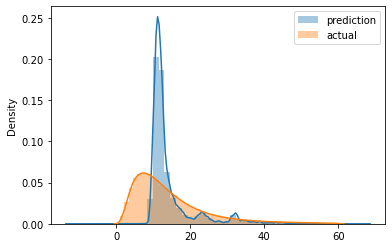

In [26]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [23]:
#Answer 5

mean_squared_error(y_train, y_pred, squared=False)
#our model is wrong by the avg of 7.64 minutes

7.649140464167203

### Running the model on the validation data

In [24]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [25]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [26]:
len(df_train), len(df_val)

(3009173, 2855951)

In [27]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO']= df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [ ]:
df_val

In [1]:
#PU_DO - is an interaction feature, they are more informatve

categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

#validaton dictionary
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

NameError: name 'DictVectorizer' is not defined